# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use Pandas to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

## Import libraries

In [22]:
import numpy as np
import pandas as pd

# Load LendingClub dataset

We will be using a dataset from the [LendingClub](https://www.lendingclub.com/). A parsed and cleaned form of the dataset is availiable [here](https://github.com/learnml/machine-learning-specialization-private). Make sure you **download the dataset** before running the following command.

In [23]:
loans = pd.read_csv('lending-club-data.csv')

## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [24]:
loans.columns

Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'is_inc_v', u'issue_d', u'loan_status', u'pymnt_plan', u'url', u'desc',
       u'purpose', u'title', u'zip_code', u'addr_state', u'dti',
       u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'mths_since_last_major_derog', u'policy_code', u'not_compliant',
       u'status', u'inactiv

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [25]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis = 1)

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

In [26]:
total_safe_loans = (loans['safe_loans'] == 1).sum()
total_risky_loans = (loans['safe_loans'] == -1).sum()

print 'Value: 1\tCount: ' + str(total_safe_loans) + ' Percent: ' + str(float(total_safe_loans)/ len(loans) * 100)
print 'Value:-1\tCount: ' + str(total_risky_loans) + ' Percent: ' + str(float(total_risky_loans)/ len(loans) * 100)

Value: 1	Count: 99457 Percent: 81.1185331996
Value:-1	Count: 23150 Percent: 18.8814668004


You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [27]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

## Data preprocessing

* Apply one-hot encoding to loans.
* Load the JSON files into the lists train_idx and validation_idx.
* Perform train/validation split using train_idx and validation_idx.

### One Hot Encoding

In [28]:
loans = pd.get_dummies(loans)

### Load the JSON files into the lists train_idx and validation_idx

In [29]:
def load_json_data(file_name):
    '''
    Loads the json data from 'file_name', converts it into a python list and returns it
    '''
    with open(file_name) as f:
        import json
        return json.load(f)

In [30]:
train_idx = load_json_data('module-5-assignment-1-train-idx.json')
validation_idx = load_json_data('module-5-assignment-1-validation-idx.json')

## Split data into training and validation sets

We split the data into training and validation sets using an 80/20 split.

**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [31]:
train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

In [32]:
#distribution of 'safe_loans' before splitting the data
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print "Number of safe loans  : %s" % len(safe_loans_raw)
print "Number of risky loans : %s" % len(risky_loans_raw)

Number of safe loans  : 99457
Number of risky loans : 23150


Now, write some code to compute below the percentage of safe and risky loans in the dataset and validate these numbers against what was given earlier in the assignment:

In [ ]:
print "Percentage of safe loans  :", 
print "Percentage of risky loans :", 

One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed=1` so everyone gets the same results.

The above instuctions apply to SFrame users. Learners using pandas just need to train_idx and validation_idx to obtain the training and validation sets.

In [33]:
loans_data = train_data.append(validation_data)
safe_loans = loans_data[loans_data[target] == 1]
risky_loans = loans_data[loans_data[target] == -1]

Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [59]:
print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502236174422
Percentage of risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

# Use decision tree to build a classifier

Now, let's use the built-in sklearn [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to create a loan prediction model on the training data. (In the next assignment, you will implement your own decision tree learning algorithm.)  Our feature columns and target column have already been decided above.

In [40]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model.fit(train_data.drop(target, axis=1), train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Visualizing a learned model

A tree with depth 6 can be hard to visualize graphically.  Here, we instead learn a smaller model with **max depth of 2** to gain some intuition by visualizing the learned tree.

In [41]:
small_model = DecisionTreeClassifier(max_depth=2)
small_model.fit(train_data.drop(target, axis=1), train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

To visualize our learned model, we make use of [GraphViz](http://graphviz.readthedocs.io/en/latest/#). GraphViz needs to be downloaded from [this](http://www.graphviz.org/Download.php) link and installed.

small_model is exported as a 'dot' file which is then used by GraphViz to produce the png image.

In [43]:
from sklearn.tree import export_graphviz

export_graphviz(small_model, out_file = 'small_model.dot', feature_names = train_data.drop(target, axis=1).columns)

Ensure that the small_model.dot file has been generated. Also, make sure that GraphViz is installed. 

Execute the following command on your command line in the location where small_model.dot is saved.

dot -Tpng small_model.dot -o small_model.png

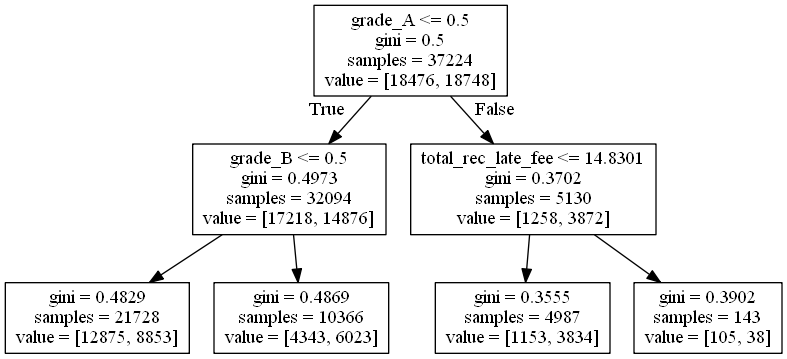

In [44]:
from IPython.display import Image
Image('small_model.png')

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [45]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
79,0,10,16.85,1,1,96.4,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24,0,3,13.97,0,1,59.5,0.0,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
41,0,11,16.33,1,1,62.1,0.0,-1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Explore label predictions

Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

**Quiz Question:** What percentage of the predictions on `sample_validation_data` did `decision_tree_model` get correct?

## Explore probability predictions

For each row in the **sample_validation_data**, what is the probability (according **decision_tree_model**) of a loan being classified as **safe**? 


**Hint:** Use `predict_proba` method to make **probability** predictions using **decision_tree_model** on `sample_validation_data`:

**Quiz Question:** Which loan has the highest probability of being classified as a **safe loan**?

**Checkpoint:** Can you verify that for all the predictions with `probability >= 0.5`, the model predicted the label **+1**?

### Tricky predictions!

Now, we will explore something pretty interesting. For each row in the **sample_validation_data**, what is the probability (according to **small_model**) of a loan being classified as **safe**?

**Hint:** Use `predict_proba` method to make **probability** predictions using **small_model** on `sample_validation_data`:

**Quiz Question:** Notice that the probability preditions are the **exact same** for the 2nd and 3rd loans. Why would this happen?

## Visualize the prediction on a tree


Note that you should be able to look at the small tree, traverse it yourself, and visualize the prediction being made. Consider the following point in the **sample_validation_data**

In [49]:
sample_validation_data.iloc[1]

short_emp                      0.00
emp_length_num                10.00
dti                           16.85
last_delinq_none               1.00
last_major_derog_none          1.00
revol_util                    96.40
total_rec_late_fee             0.00
safe_loans                     1.00
grade_A                        0.00
grade_B                        0.00
grade_C                        0.00
grade_D                        1.00
grade_E                        0.00
grade_F                        0.00
grade_G                        0.00
sub_grade_A1                   0.00
sub_grade_A2                   0.00
sub_grade_A3                   0.00
sub_grade_A4                   0.00
sub_grade_A5                   0.00
sub_grade_B1                   0.00
sub_grade_B2                   0.00
sub_grade_B3                   0.00
sub_grade_B4                   0.00
sub_grade_B5                   0.00
sub_grade_C1                   0.00
sub_grade_C2                   0.00
sub_grade_C3                

Use the `small_model.png` image loaded above to answer the following question.

**Quiz Question:** Based on the visualized tree, what prediction would you make for this data point (according to small_model)? (If you don't have Graphviz, you can answer this quiz question by executing the next part.)

Now, let's verify your prediction by examining the prediction made using sklearn.  Use the `.predict` function on `small_model`.

# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

In [53]:
print(small_model.score(train_data.drop(target, axis=1) , train_data[[target]]))
print(decision_tree_model.score(train_data.drop(target, axis=1), train_data[[target]]))

0.613502041694
0.640527616591


**Checkpoint:** You should see that the **small_model** performs worse than the **decision_tree_model** on the training data.


Now, let us evaluate the accuracy of the **small_model** and **decision_tree_model** on the entire **validation_data**, not just the subsample considered above.

**Quiz Question:** What is the accuracy of `decision_tree_model` on the validation set, rounded to the nearest .01?

## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [55]:
big_model = DecisionTreeClassifier(max_depth=10)
big_model.fit(train_data.drop(target, axis=1), train_data[[target]])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Now, let us evaluate **big_model** on the training set and validation set.

In [57]:
print(big_model.score(train_data.drop(target, axis=1), train_data[[target]]))
print(big_model.score(validation_data.drop(target, axis=1), validation_data[[target]]))

0.66379217709
0.626561826799


**Checkpoint:** We should see that **big_model** has even better performance on the training set than **decision_tree_model** did on the training set.

**Quiz Question:** How does the performance of **big_model** on the validation set compare to **decision_tree_model** on the validation set? Is this a sign of overfitting?

### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [60]:
predictions = decision_tree_model.predict(validation_data.drop(target, axis=1))

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:

**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

**Quiz Question:** Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?